# Machine Learning Model: Email Spam Filtering

<img src='spam-filtering-solutions.jpg'>

## Define the problem and Goals

We've all been recipients of unwanted emails at some point. These emails, commonly known as spam or junk mail, are unsolicited electronic messages sent to a large number of recipients simultaneously. They typically contain irrelevant content, fraudulent offers, or, more alarmingly, phishing attempts.


In this project, we will use Python to create a system for detecting email spam. Our goal is to train a machine learning model to recognize and classify emails as either spam or legitimate (ham). The ultimate objective is to effectively filter out undesirable and potentially harmful emails from our inbox.


## The dataset

The dataset we're referring to is the "SMS Spam Collection" dataset. This dataset is commonly used for text classification tasks, specifically for spam detection in text messages. Below is a description of the dataset:

**Content:**
- The dataset contains a collection of SMS (Short Message Service) text messages.
- Each message is tagged with one of two labels: "ham" or "spam."
- The dataset consists of two columns:
  - **v1:** This column contains the label for each message, where "ham" represents legitimate (non-spam) messages, and "spam" represents spam messages.
  - **v2:** This column contains the raw text of the SMS messages.

**Size:**
- The dataset consists of 5,574 SMS messages.

**Sources:**
The dataset was collected from various sources on the internet, including:
1. A collection of 425 SMS spam messages manually extracted from the Grumbletext website, a UK forum where users discuss SMS spam.
2. A subset of 3,375 randomly chosen legitimate (ham) messages from the NUS SMS Corpus (NSC), collected for research at the National University of Singapore.
3. A list of 450 legitimate (ham) SMS messages collected from Caroline Tag's PhD Thesis.
4. The SMS Spam Corpus v.0.1 Big, which contains 1,002 legitimate (ham) SMS messages and 322 spam messages.

**Additional Information:**
- The dataset has been used in academic research to study SMS spam filtering, and various machine learning methods have been applied to it for classification tasks.

**Reference:**
- The dataset is associated with the following paper: "Contributions to the Study of SMS Spam Filtering: New Collection and Results" by Almeida, T.A., Gómez Hidalgo, J.M., and Yamakami, A. It was presented at the 2011 ACM Symposium on Document Engineering (DOCENG'11).


## Import necessary library

In [1]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from collections import Counter
from tensorflow import keras
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile
import string
import nltk
import re

# Load the dataset

In [2]:
zip_file = 'SMS Spam Collection Dataset.zip'

In [3]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    zip_ref.extractall()

In [4]:
for file in file_list:
    print(f"Extracted: {file}")

Extracted: spam.csv


In [5]:
spam_dataset = pd.read_csv("spam.csv",encoding='latin-1')
spam_dataset

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [6]:
# Drop unnecessary columns from the DataFrame

columns_to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
spam_dataset.drop(columns=columns_to_drop, inplace=True)

In [7]:
spam_dataset

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
spam_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
spam_dataset.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
spam_dataset.isna().sum()

v1    0
v2    0
dtype: int64

In [11]:
new_column_names = {"v1":"Category", "v2":"Message"}
spam_dataset.rename(columns = new_column_names, inplace = True)

In [12]:
spam_dataset.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


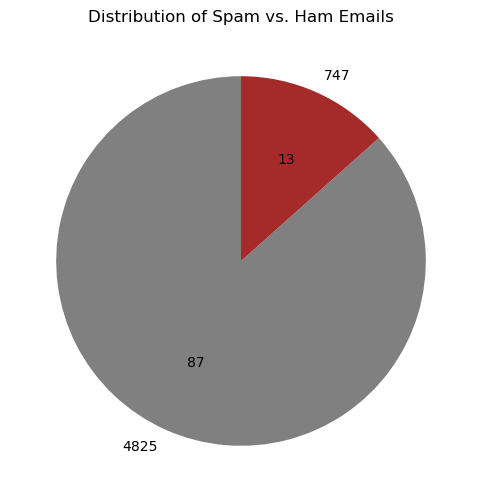

In [13]:
# Count the occurrences of each label
label_counts = spam_dataset['Category'].value_counts()

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Optional: Set the figure size
custom_colors = ['grey', 'brown']  # Replace with your desired colors

# Create the pie chart with custom colors
plt.pie(label_counts, labels=label_counts, autopct='%.0f', startangle=90, colors=custom_colors)

# Add a title
plt.title('Distribution of Spam vs. Ham Emails')

# Display the pie chart
plt.show()


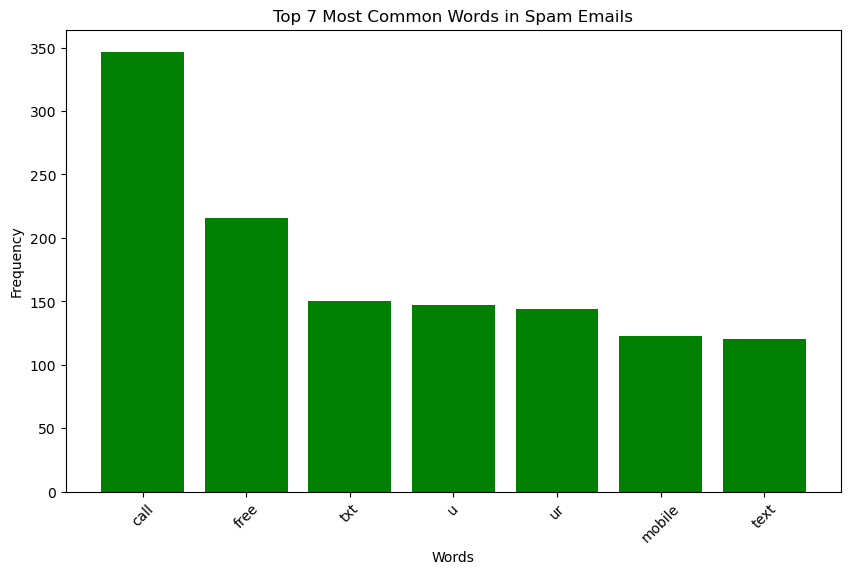

In [60]:
# Data visualization - Top 7 Most Common Words in Spam Emails

stop_words = set(stopwords.words('english'))
spam_words = " ".join(spam_dataset[spam_dataset['Category'] == 0]['Message']).split()
ham_words = " ".join(spam_dataset[spam_dataset['Category'] == 1]['Message']).split()

spam_word_freq = Counter([word.lower() for word in spam_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*spam_word_freq.most_common(7)), color='g')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 7 Most Common Words in Spam Emails')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize text (split into words)
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Join words back into text
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# Apply the cleaning function to the 'TextColumn'
spam_dataset['Message'] = spam_dataset['Message'].apply(clean_text)

# Display the cleaned DataFrame
print(spam_dataset)

     Category                                            Message
0         ham  go jurong point crazy available bugis n great ...
1         ham                            ok lar joking wif u oni
2        spam  free entry 2 wkly comp win fa cup final tkts 2...
3         ham                u dun say early hor u c already say
4         ham        nah dont think goes usf lives around though
...       ...                                                ...
5567     spam  2nd time tried 2 contact u u å£750 pound prize...
5568      ham                        ì b going esplanade fr home
5569      ham                        pity mood soany suggestions
5570      ham  guy bitching acted like id interested buying s...
5571      ham                                     rofl true name

[5572 rows x 2 columns]


In [15]:
spam_dataset['Message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u u å£750 pound prize...
5568                          ì b going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object

In [16]:
spam_dataset.Message= spam_dataset.Message.str.split('|',expand=True)[0]
spam_dataset.Message

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u u å£750 pound prize...
5568                          ì b going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object

In [17]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
spam_dataset['cleaned text'] = spam_dataset['Message'].apply(clean)
spam_dataset.head()

,Category,Message,cleaned text
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though,nah dont think goes usf lives around though


In [18]:
"""This punkt tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, 
collocations, and words that start sentences. """

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NTECH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NTECH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NTECH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
          
    return newlist 

spam_dataset['POS tagged'] = spam_dataset['cleaned text'].apply(token_stop_pos)
spam_dataset.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\NTECH\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\NTECH\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Category,Message,cleaned text,POS tagged
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,"[(go, v), (jurong, a), (point, n), (crazy, n),..."
1,ham,ok lar joking wif u oni,ok lar joking wif u oni,"[(ok, a), (lar, a), (joking, n), (wif, n), (u,..."
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,free entry wkly comp win fa cup final tkts st ...,"[(free, a), (entry, n), (wkly, v), (comp, n), ..."
3,ham,u dun say early hor u c already say,u dun say early hor u c already say,"[(u, a), (dun, n), (say, v), (early, a), (hor,..."
4,ham,nah dont think goes usf lives around though,nah dont think goes usf lives around though,"[(nah, a), (dont, n), (think, n), (goes, v), (..."


In [20]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    def get_wordnet_pos(tag):
        # Map POS tags to WordNet tags
        tag = tag[0].upper()
        tag_dict = {"J": "a", "N": "n", "R": "r", "V": "v"}
        return tag_dict.get(tag, "n")  # Default to noun if not found

    lemma_text = ""
    for word, pos in pos_tag(word_tokenize(text)):
        wordnet_pos = get_wordnet_pos(pos)
        lemma = wordnet_lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemma_text += lemma + " "
    
    return lemma_text.strip()

# Assuming you have a DataFrame named spam_dataset with a 'cleaned text' column
spam_dataset['Lemma'] = spam_dataset['cleaned text'].apply(lemmatize)
spam_dataset.head()


,Category,Message,cleaned text,POS tagged,Lemma
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,"[(go, v), (jurong, a), (point, n), (crazy, n),...",go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni,ok lar joking wif u oni,"[(ok, a), (lar, a), (joking, n), (wif, n), (u,...",ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,free entry wkly comp win fa cup final tkts st ...,"[(free, a), (entry, n), (wkly, v), (comp, n), ...",free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say,u dun say early hor u c already say,"[(u, a), (dun, n), (say, v), (early, a), (hor,...",u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though,nah dont think goes usf lives around though,"[(nah, a), (dont, n), (think, n), (goes, v), (...",nah dont think go usf life around though


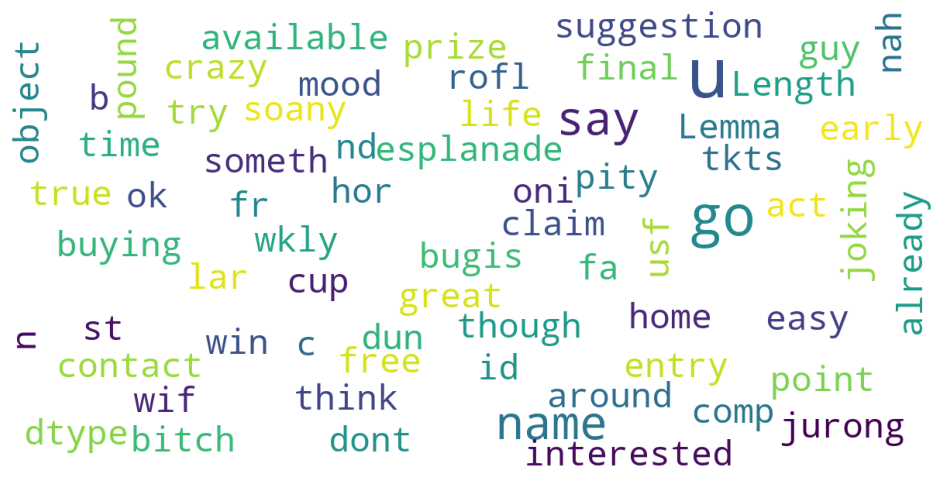

In [21]:

stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(spam_dataset.Lemma)

In [22]:
spam_dataset.loc[spam_dataset["Category"] == "spam", "Category"] = 0
spam_dataset.loc[spam_dataset["Category"] == "ham", "Category"] = 1

In [23]:
x = spam_dataset['Lemma']
y = spam_dataset['Category']

In [24]:
x

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                nah dont think go usf life around though
                              ...                        
5567    nd time try contact u u pound prize claim easy...
5568                               b go esplanade fr home
5569                           pity mood soany suggestion
5570    guy bitch act like id interested buying someth...
5571                                       rofl true name
Name: Lemma, Length: 5572, dtype: object

## Models Development

### Split the dataset

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

In [26]:
print("the x_train shape :", X_train.shape)
print("the y_train shape :", Y_train.shape)
print("the x_test shape :", X_test.shape)
print("the y_test shape :", Y_test.shape)

the x_train shape : (4457,)
the y_train shape : (4457,)
the x_test shape : (1115,)
the y_test shape : (1115,)


In [27]:
# Initialize TF-IDF Vectorizer
feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)

In [28]:
# Feature extraction for training and testing data
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [29]:
# Convert Y_train and Y_test to integer type
Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [30]:
print(X_train)

3075    mum hope great day hop text meet well full lif...
1787                                    yessura sun tvlol
1614           sef dey laugh meanwhile hows darling anjie
4304                                  yo come carlos soon
3266                               ok come n pick u engin
                              ...                        
789                            gud mrng dear hav nice day
968                             willing go aptitude class
1667          dad gon na call get work ask crazy question
3321    ok darlin supose ok worry muchi film stuff mat...
1688                            nan sonathaya soladha bos
Name: Lemma, Length: 4457, dtype: object


In [31]:
print(X_train_features)

  (0, 12)	0.3572216793616925
  (0, 3040)	0.2674799288989356
  (0, 3320)	0.2548203243880039
  (0, 5496)	0.21976199094206944
  (0, 2435)	0.33189591412417524
  (0, 1257)	0.41151630736746986
  (0, 2183)	0.4917953697087793
  (0, 2436)	0.2453178173938119
  (0, 3549)	0.32569056296838617
  (1, 5767)	0.6198087062380064
  (1, 5325)	0.4813256022103305
  (1, 6381)	0.6198087062380064
  (2, 201)	0.46869878054347125
  (2, 1241)	0.40128028378489705
  (2, 2465)	0.3194895777780934
  (2, 2982)	0.36026507346924086
  (2, 1362)	0.4095760327570654
  (2, 4786)	0.46869878054347125
  (3, 5080)	0.49526468460211687
  (3, 797)	0.602743871929324
  (3, 1010)	0.3428277793689461
  (3, 6392)	0.5233372055668981
  (4, 1631)	0.7544462971949563
  (4, 4082)	0.44164951191794594
  (4, 3817)	0.3496611780286608
  :	:
  (4452, 1257)	0.2978585439927872
  (4453, 259)	0.6773783123935929
  (4453, 6162)	0.5799429670199979
  (4453, 947)	0.45257571400026503
  (4454, 1215)	0.41804999042256946
  (4454, 2130)	0.37583069651942147
  (4454, 

### Logistic Regression Model

In [32]:
# Create and Fit Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_features, Y_train)

LogisticRegression()

In [33]:
 #Make predictions on the training data
predict_train_data=model.predict(X_train_features)
predict_train_data

array([1, 1, 1, ..., 1, 1, 1])

In [34]:
#Model Evaluation
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_train_data=accuracy_score(Y_train,predict_train_data)
print("Accuracy on training data: ",accuracy_train_data)

Accuracy on training data:  0.9661207089970832


In [35]:
# Make predictions on the testing data
predict_test_data=model.predict(X_test_features)

In [36]:
#Model Evaluation
accuracy_test_data=accuracy_score(Y_test,predict_test_data)
print("acuuracy on test data: ",accuracy_test_data)

acuuracy on test data:  0.9605381165919282


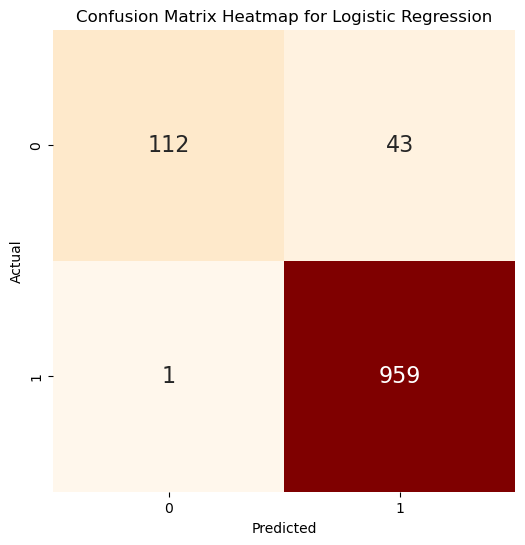

In [37]:
# Calculate the confusion matrix
confusion = confusion_matrix(Y_test, predict_test_data)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='OrRd', cbar=False, square=True, annot_kws={"size": 16})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap for Logistic Regression')

plt.show()

### SVM Model

In [38]:
svm = SVC()
svm.fit(X_train_features, Y_train)

SVC()

In [39]:
svm_train_prediction =  svm.predict(X_train_features)
svm_train_prediction

array([1, 1, 1, ..., 1, 1, 1])

In [40]:
svmaccuracy_train_data=accuracy_score(svm_train_prediction,Y_train)
print("SVM Accuracy on training data: ",svmaccuracy_train_data)

SVM Accuracy on training data:  0.9964101413506843


In [41]:
# Make predictions on the testing data
svmpredict_test_data=svm.predict(X_test_features)

In [42]:
#Model Evaluation
svmaccuracy_test_data=accuracy_score(Y_test,svmpredict_test_data)
print("acuuracy on test data: ",svmaccuracy_test_data)

acuuracy on test data:  0.9766816143497757


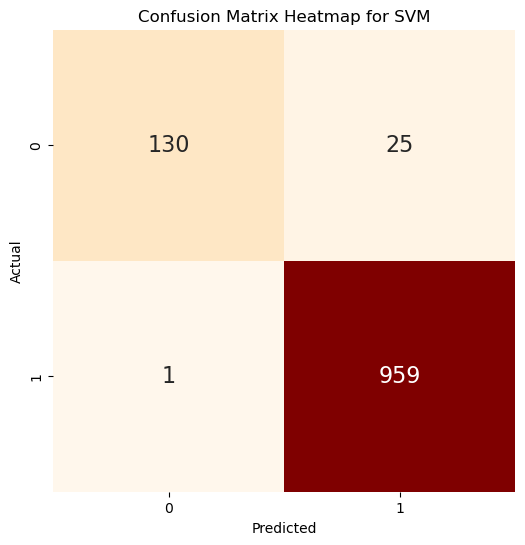

In [43]:
# Calculate the confusion matrix
confusion = confusion_matrix(Y_test, svmpredict_test_data)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='OrRd', cbar=False, square=True, annot_kws={"size": 16})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap for SVM')

plt.show()

### CNN model

In [44]:
texts = spam_dataset['Lemma']
labels = spam_dataset['Category']

In [47]:
# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Tokenization and padding (replace with your own preprocessing steps)
max_words = 20
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_words)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = keras.Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_words),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two classes: "spam" and "ham"
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=2, validation_split=0.2)

Epoch 1/5
1783/1783 [==============================] - 8s 4ms/step - loss: 0.3017 - accuracy: 0.8937 - val_loss: 0.2558 - val_accuracy: 0.9204
Epoch 2/5
1783/1783 [==============================] - 6s 3ms/step - loss: 0.2623 - accuracy: 0.9069 - val_loss: 0.2475 - val_accuracy: 0.9215
Epoch 3/5
1783/1783 [==============================] - 6s 3ms/step - loss: 0.2573 - accuracy: 0.9125 - val_loss: 0.2474 - val_accuracy: 0.9238
Epoch 4/5
1783/1783 [==============================] - 6s 3ms/step - loss: 0.2474 - accuracy: 0.9164 - val_loss: 0.2554 - val_accuracy: 0.8890
Epoch 5/5
1783/1783 [==============================] - 5s 3ms/step - loss: 0.2469 - accuracy: 0.9147 - val_loss: 0.2712 - val_accuracy: 0.9103


In [48]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


35/35 [==============================] - 0s 3ms/step - loss: 0.2510 - accuracy: 0.9229
Test loss: 0.25096550583839417, Test accuracy: 0.9228699803352356


In [51]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

35/35 [==============================] - 0s 3ms/step


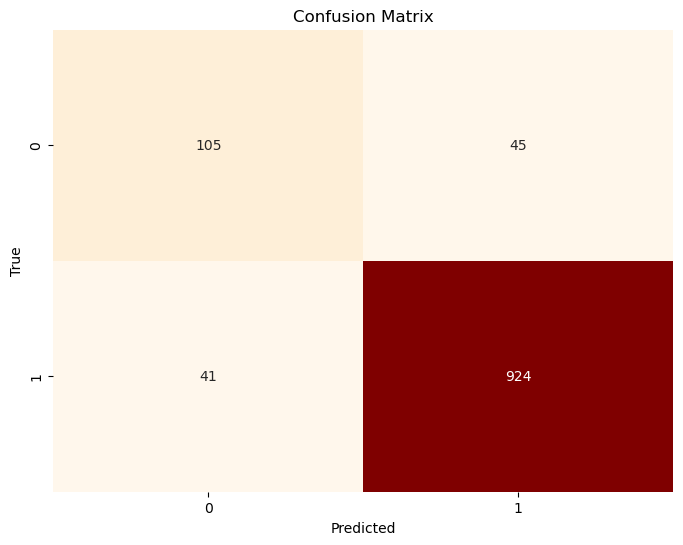

In [53]:
# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='OrRd', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## conclusion

In our project, we followed a series of steps to build an email spam detection system. Here's a summary of the key steps and the results we obtained:

**Step 1: Data Loading**
- We started by loading the dataset, which serves as the foundation for our email spam detection model.

**Step 2: Data Description**
- We conducted a data description to gain insights into the dataset's characteristics and understand its features. This helped us get a better grasp of the data we were working with.

**Step 3: Feature Selection**
- To streamline our analysis and model training, we performed feature selection by removing columns that were not deemed relevant or helpful for our spam detection task.

**Step 4: Text Cleaning**
- Text cleaning was a crucial preprocessing step where we processed and cleaned the text data to ensure it was suitable for analysis and model training.

**Step 5: Model Building**
- We applied several machine learning models to train and evaluate their performance in email spam detection. Here are the results for each model:

1. **Logistic Regression Model:**
   - Accuracy on training data: 0.9661
   - Accuracy on test data: 0.9605

2. **Support Vector Machine (SVM):**
   - SVM Accuracy on training data: 0.9964
   - Accuracy on test data: 0.9767

3. **Convolutional Neural Network (CNN):**
   - Accuracy on training data: 0.9103
   - Test accuracy: 0.9229

These results demonstrate the performance of each model in terms of accuracy. The SVM model achieved the highest accuracy on both the training and test datasets, indicating its effectiveness in classifying emails as spam or ham. The Logistic Regression model also performed well, while the CNN model, although not as accurate as the other models, still provided a respectable level of accuracy.
